# Grammar Mistakes Detector using BERT

In this notebook a model is trained to detect if the given text has grammar mistakes. I made a web application that uses this model, fell free to play with it https://mostafa-portfolio.azurewebsites.net/  

For training the model the "Corpus of Linguistic Acceptability (CoLA)" data set was used. The data set contains 9594 sentences which are labeled as grammatically correct or no.

The BERT model is a powerful pretrained model developed by Google for NLP purposes. In this notebook we are adding an extra layer to the BERT model and training the whole model to detect grammar mistakes.



To run this notebook you first need to load the data set into your Google drive, you can do that as follows:

1- Downoad the "Corpus of Linguistic Acceptability (CoLA)" data set from here https://drive.google.com/drive/folders/12Uj3EycUF5zmCcBD30hv4baeHywqkGbK?usp=sharing

2- Unzip the downloaded folder and add the folder inside it "The_Corpus_of_Linguistic_Acceptability" to your google drive

3- In the notebook above select "Runtime" --> "Change Runtime type" --> And select "GPU" so you can train faster

4- Run the notebook

5- While exceuting cell26, the notebook will ask you to click on a link to validate your google drive so it can read the Dataset from there.


That's it !!

# Install the hugging face library which contains the pre-trained BERT model 

In [1]:
!pip install pytorch_pretrained_bert pytorch-nlp pytorch-nlp

     |████████████████████████████████| 133kB 14.3MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 133kB 53.9MB/s 
     |████████████████████████████████| 7.2MB 24.7MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
ERROR: botocore 1.20.7 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


# Import the required Libraries

In [2]:
import io
import torch
import tensorflow as tf
import pandas as pd
import numpy as np
import zipfile
import math
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertAdam, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import SequentialSampler, RandomSampler, TensorDataset, DataLoader
from keras.preprocessing.sequence import pad_sequences

# Load The Dataset

We first mount the google drive, so that we can use the data set from the GoogleDrive .

There are 3 files for training, we upload the three files, and combine them in one pandas dataframe.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path     = '/content/drive/MyDrive/The_Corpus_of_Linguistic_Acceptability/raw/'
files_to_read = ['in_domain_dev.tsv', 'in_domain_train.tsv', 'out_of_domain_dev.tsv']

# list to store the three dataframes of the three files
list_of_dataframes = []

# Read the the three files of the data set
for filename in files_to_read:
    df_local = pd.read_csv((base_path + filename), delimiter='\t', 
                           names=['sentence_source', 'label', 'label_notes', 'sentence'], index_col=None, header=0)
    list_of_dataframes.append(df_local)

# Concatinate the three dataframes in one dataframe
df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)

In [5]:
print('df.shape: ', df.shape)
no_of_sentences = df.shape[0]
print('no_of_sentences in the data set: ', no_of_sentences)

df.shape:  (9591, 4)
no_of_sentences in the data set:  9591


In [6]:
df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,The weights made the rope stretch over the pul...
1,gj04,1,NaN,The mechanical doll wriggled itself loose.
2,cj99,1,NaN,"If you had eaten more, you would want less."
3,cj99,0,*,"As you eat the most, you want the least."
4,cj99,0,*,"The more you would want, the less you would eat."


The important two columns are the sentence column and the label column. A label of "1" means no grammar error, "0" means grammar error.

# Prepare Data for BERT Model

The BERT model has some prequisites to work properly, we will implement them one by one below.

First we create sentence and label lists, For BERT to work each sentence should have a "CLS" token before it and a "SEP" toekn after it. 

In [7]:
sentences = df.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

BERT input is not simply the complete raw text, we first need to break the text down to small tokens, for that we use the BERT Tokenizer.

Note that we are using the 'bert-base-uncased' model, this model will just ignore the case in the input text, we are using it and not the Bert-large model because it is smaller and a bit faster.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_text = [tokenizer.tokenize(sentence) for sentence in sentences]
print ("First sentence raw:")
print(sentences[0])

print ("First sentence tokenized:")
print (tokenized_text[0])

100%|██████████| 231508/231508 [00:00<00:00, 20146791.93B/s]


First sentence raw:
[CLS] The weights made the rope stretch over the pulley. [SEP]
First sentence tokenized:
['[CLS]', 'the', 'weights', 'made', 'the', 'rope', 'stretch', 'over', 'the', 'pull', '##ey', '.', '[SEP]']


Let's find out the length of the longest sentence in the training set.

In [9]:
df['word_count'] = df['sentence'].apply(lambda x : len(str(x).split(" ")))
# get id of longest sentence
id_max = df['word_count'].idxmax()
print('length of longest sengence: ', df['word_count'].iloc[id_max])
# The longest tweet is 42 words long, let's use LENGTH_MAX = 64
LENGTH_MAX = 64

length of longest sengence:  42


BERT model is trained with a certain vocabulary, in this vocaubulary each word has a number. The BERT model will not take the tokenized words as words, we need to convert them to the word's number in the BERT vocabularly. 

In [10]:
input_ids = [tokenizer.convert_tokens_to_ids(word) for word in tokenized_text]

print('input_ids of the first sentence: ', input_ids[0])

input_ids of the first sentence:  [101, 1996, 15871, 2081, 1996, 8164, 7683, 2058, 1996, 4139, 3240, 1012, 102]


We pad the input sentences with 0s so that all the training sentences have the same length

In [11]:
input_ids = pad_sequences(input_ids, maxlen=LENGTH_MAX, dtype="long", truncating="post", padding="post")
print('input_ids after padding: ', input_ids[0])

input_ids after padding:  [  101  1996 15871  2081  1996  8164  7683  2058  1996  4139  3240  1012
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


The BERT model requires an attention mask for eac input sentence. It is very simple, we just add a 1 for each word and 0 for the padding.


In [12]:
attention_masks = []

for word in input_ids:
  word_mask = [float(i>0) for i in word]
  attention_masks.append(word_mask)

print('attention mask for the first training sentence: ', attention_masks[0])

attention mask for the first training sentence:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


We normally split our data set to three sets, train dev and test. But here to get the maximum possible accuracy for our model, we will divide our data only to train and dev sets 90% and 10% respectively.

In [13]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=1000, test_size=0.1)
train_masks, validation_masks = train_test_split(attention_masks, random_state=1000, test_size=0.1)

In [14]:
# The BERT model needs the input to be tensors, so we do so :)

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [15]:
# In the original BERT paper section 4.1 the authors selected a batch size of 32 for fine tuning, so we also use the same value
batch_size = 32

# Create an iterator to supply the data on demand, this is better than for loop as it only supplies the data on demand ths saving memory.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [16]:
# We create our model by importing the original BERT model and adding a layer of only 2 outputs on top o fit. 
#2 Outputs because we have 2 possibilities, grammar mistake detected or on 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

100%|██████████| 407873900/407873900 [00:06<00:00, 63586203.61B/s]


In [17]:
#We create the optimizer, In the original BERT paper section 4.1 the authors recommended a learning rate among 5e-5, 4e-5, 3e-5, and 2e-5
optimizer = BertAdam(model.parameters(),lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [18]:
# Method to calculate accuracy
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Model training
Now the final step is to train the model, or to be more accurate to fine tune it!

In each epoch there are two steps training step and validation step.

In [19]:
def training_step(history):
  
  # This step doesn't train the model, it just sets it to training mode.
  model.train()
  
  training_loss = 0
  
  no_of_train_sentences = train_inputs.shape[0]

  no_of_steps = math.ceil(no_of_train_sentences/batch_size)
  steps_counter = 0;

  # Training loop
  for step, batch in enumerate(train_dataloader):

    # load the inputs from the dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Clear out the gradients
    optimizer.zero_grad()

    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    history.append(loss.item())   

    # Backward pass
    loss.backward()

    # Update parameters and take a step using the computed gradient
    optimizer.step()
        
    training_loss += loss.item()
    
    steps_counter+=1

    # Print the message only each 30 steps to avoid having too much logs
    if (steps_counter%30 == 0):
      print('training step ', steps_counter, 'of', str(no_of_steps),  'done!')
    
    
  print("Training loss: ", (training_loss/no_of_steps))

  return history

In [20]:
def validation_step():

  # This step doesn't evaluate the model, it just sets it to evaluation mode.
  model.eval()

  validation_accuracy = 0

  no_of_validation_sentences = validation_inputs.shape[0]

  no_of_steps = math.ceil(no_of_validation_sentences/batch_size)
  steps_counter = 0;

  #Validation loop
  for batch in validation_dataloader:

    # load the inputs from the dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits.numpy()
    label_ids = b_labels.numpy()

    validation_accuracy += calculate_accuracy(logits, label_ids)
    
    steps_counter+=1
    
    # Print the message only each 30 steps to avoid having too much logs
    if (steps_counter%30 == 0):
      print('validation step ', steps_counter, 'of', str(no_of_steps),  'done!')

  print("Validation Accuracy: ", (validation_accuracy/no_of_steps))


In [21]:
# Number of training epochs (The authors of the original paper recommends 2-4 epochs for fine tuning) 
epochs = 2

# Store the training loss and accuracy for plotting
history = []

print()

for i in range(epochs):
  
  history = training_step(history)
  
  validation_step()  

  print('--> Epoch ', (i+1), ' of ', epochs, ' done')
  print()

/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


training step  30 of 270 done!
training step  60 of 270 done!
training step  90 of 270 done!
training step  120 of 270 done!
training step  150 of 270 done!
training step  180 of 270 done!
training step  210 of 270 done!
training step  240 of 270 done!
training step  270 of 270 done!
Training loss:  0.4851789823836751
validation step  30 of 30 done!
Validation Accuracy:  0.7864583333333334
--> Epoch  1  of  2  done

training step  30 of 270 done!
training step  60 of 270 done!
training step  90 of 270 done!
training step  120 of 270 done!
training step  150 of 270 done!
training step  180 of 270 done!
training step  210 of 270 done!
training step  240 of 270 done!
training step  270 of 270 done!
Training loss:  0.23408156263607519
validation step  30 of 30 done!
Validation Accuracy:  0.809375
--> Epoch  2  of  2  done



# Save the trained model
Save the model so we can use it later for prediction.

In [22]:
torch.save(model, 'complete_model.pt')

# Visualize the Training Process

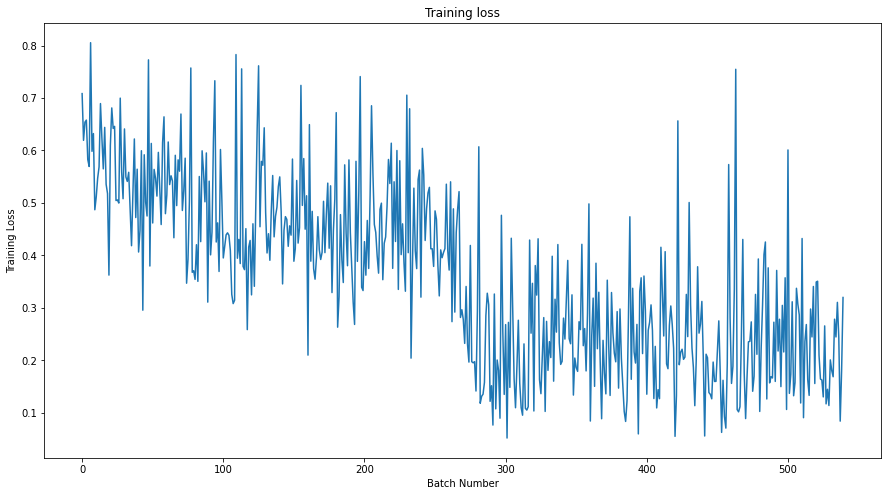

In [23]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch Number")
plt.ylabel("Training Loss")
plt.plot(history)
plt.show()

And that's it! 

Now we have trained our model to detect Grammar mistakes. 

I deployed this model in a web app, you can have a look here https://mostafa-portfolio.azurewebsites.net/ 